In [16]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from itertools import product

## 6.4 Congestion games

### 6.4.1 Definition

Congestion games are where agents pay a cost for their actions depending on how many other people take the same action. We have a set of resources, and a cost function. The actions are whether or not to claim the resource. The cost is the same across all agents and only depends on the total number of agents claiming the same resource. 

This kind of game appears quite often. As the name suggests one obvious case is when there are two or more different routes from A to B which both take different amounts of time depending on the number of people who choose each. E.g., a highway vs a backroad. But other cases are also common, for instance choosing which bar to go to. In that case there is a cost if there are too may people or too few people (the cost function can be positive!). There seem to be different definitions flying around and in some (like the example above) each actor may only choose 1 resource, but in general there aren't limits. 

### 6.4.2 Computing equilibria

Congestion games have a pure-strategy equilibrium. Not only that, but the equilibrium can be found simply by iteratively updating each player's response for each action. Proof of this is incoming, but first a demonstration:

Say we have two resources A and B. The cost is linear increasing with the number of people:

In [17]:
# This function computes a 'better-response'. 
# However, it is only applicable if every action is possible as it is in the below case. 
# When actions are tied together you need to actually compute the best response over all valid combinations of actions.
def MyopicBestResponse(cost_funcs, n_players):
    num_choices = len(cost_funcs)
    strategies = np.random.randint(0,2,(n_players, num_choices))
    any_change = True
    while any_change:
        any_change = False
        for player in range(n_players):
            sum_others = np.sum(strategies,axis=0)-strategies[player]
            for choice in range(num_choices):
                cost = cost_funcs[choice](sum_others[choice]+1)
                if cost>0 and strategies[player,choice]==1:
                    any_change = True
                    strategies[player,choice] = 0
                if cost<0 and strategies[player,choice]==0:
                    any_change = True
                    strategies[player,choice] = 1
    print(strategies)

costA = lambda x: -3 + 2*x
costB = lambda x: -1.5 + x
print("example equilibria")
MyopicBestResponse([costA,costB], 2)

example equilibria
[[1 0]
 [0 1]]


In this case the equilibria are:

$$
\begin{bmatrix}
1 & 1 \\
0 & 0
\end{bmatrix}
\text{or}
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
\text{or}
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\text{or}
\begin{bmatrix}
0 & 0 \\
1 & 1
\end{bmatrix}
$$

I.e., each resource gets 1 person. It gets more interesting with more people.

In [18]:
costA = lambda x: -5 + x
costB = lambda x: -20 + x**2
MyopicBestResponse([costA,costB], 10)

[[0 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 1]]


Now obviously the idea of MyopicBestResponse is not going to work for all normal-form games, such as the matching pennies problem, but it does work for a subset, called Potential games. 

### 6.4.3 Potential games

A game over $N$ players, $A$ actions, and $u$ utilities is a *potential game* if there is a function $P$ mapping action profiles to a number such that $u_i(a_i,a_{-i})-u_i(a_i^\prime,a_{-i})$ = $P(a_i,a_{-i})-P(a_i^\prime,a_{-i})$. I.e., all agents share the same basic utility function. 

The matching pennies game does not satisfy this constraint:

$
\begin{array}{c|ccc}
\text{} & A & B \\
\hline
\text{A} & 1,-1 & -1,1 \\
\text{B} & -1,1 & 1,-1 \\
\end{array}
$

For instance, say the other player goes A. For the row player the benefit of going A instead of B is 2. But for the column player the benefit is -2.

The staghunt does fit the definition:

$
\begin{array}{c|ccc}
\text{} & C & D \\
\hline
\text{C} & 3,3 & 0,1 \\
\text{D} & 1,0 & 1,1 \\
\end{array}
$

It doesn't matter whether you are row or column the difference is the same conditional on the other player's action.

**Theorem 6.4.5:** Every (finite) potential game has a pure-strategy equilibrium.

Proof is straightforward. Take the argmax of $P$ over all possible action profiles. If it were possible for any player to improve their position they would need to have $u_i(a_i,a_{-i})<u_i(a_i^\prime,a_{-i})$ for some $a_i^\prime$. But this would then imply $P(a_i,a_{-i})<P(a_i^\prime,a_{-i})$, which can't be true, as $P(a)$ was selected as the highest. Simple!

**Theorem 6.4.6:** Every congestion game is a potential game.

Let's definte the potential function $P(a)=\sum_{r\in R} \sum_{j=1}^{\#(r,a)}c_r(j)$. Now we will show that this gives the difference in utilities.

We want to look at $P(a_i,a_{-i})-P(a_i^\prime,a_{-i})$. I.e., we change the i'th player's policy. Expanding the formula gives:

$$\bigg[\sum_{r\in R} \sum_{j=1}^{\#(r,(a_i,a_{-i}))}c_r(j)\bigg]-\bigg[\sum_{r\in R} \sum_{j=1}^{\#(r,(a_i,a_{-i}))}c_r(j)\bigg]$$

We can write this in terms of the current costs of each resource before the current player's turn, PLUS the impact their turn has. The cost of each resource before is $\sum_{j=1}^{\#(r,(a_{-i}))}c_r(j)$. Therefore we get:

$$\bigg[\sum_{r\in R} \sum_{j=1}^{\#(r,(a_{-i}))}c_r(j)+\mathbf{1}_{r\in a_i}c_r(j+1) \bigg]-\bigg[\sum_{r\in R} \sum_{j=1}^{\#(r,(a_{-i}))}c_r(j)+\mathbf{1}_{r\in a_i^\prime}c_r(j+1) \bigg]$$

Which means we can remove the bit in common:

$$\bigg[\sum_{r\in R} \mathbf{1}_{r\in a_i}c_r(j+1) \bigg]-\bigg[\sum_{r\in R} \mathbf{1}_{r\in a_i^\prime}c_r(j+1) \bigg]$$

We can then rewrite as

$$\bigg[\sum_{r\in R|r\in a_i} c_r(j+1) \bigg]-\bigg[\sum_{r\in R|r\in a_i} c_r(j+1) \bigg]$$

Which is exactly the utility functions.

You can also go the other way and show that any potential game is also a congestion game, which is interesting.

Proof that MyopicBestResponse will give a pure equilibrium is now pretty simple. Every step of the iteration is guaranteed to increase $P$.

While this is a nice result, the problem remains PLS-complete (hard) and the time MyopicBestResponse takes might be exponential in certain games.

### 6.4.4 Nonatomic congestion games

A nonatomic congestion game is where we have infinite players. Instead of modelling each player we instead have $N$ 'types' of player. Agents within a type have the same set of actions they can take. Before we had each agent contributing 1 to the 'congestion' for a resource, but now we instead use a function $p_i$ which will map the action choice $a_i$ and resource $r$ into a contribution. We also add a distribution over the actions $s$, and the usual cost function $c$. The congestion on a resource ($s_r$) is then:

$$s_r = \sum_{i\in N}\sum_{a_i\in A_i}p_i(a_i,r)s(a_i)$$

This then becomes the cost to agents of type $i$ choosing $a_i$ (under $s$):

$$c_{a_i}(s) = \sum_{r\in a_i}p(a_i,r)c_r(s_r)$$

NOTE: The $p(a_i,r)$ in here is to refer to the amount of the resource that the players of that type consume. The cost-per-unit depends on the actions of all players, the actual cost to a player is this weighed by their consumption. 

Finally we can get to the total cost borne by all agents:

$$C(s)=\sum_{i\in N}\sum_{a_i\in A_i}s(a_i)c_{a_i}(s)$$

The nonatomic game also has a pure strategy equilibrium (although, this is ignoring a couple details), and all equilibria in a nonatomic congestion game have equal social cost. 

**Example:**

To give a very simple example imagine we have 1 type of player and 2 actions (route A or B). We don't allow them to choose either (this is a deviation from before, but perfectly allowed. Congestion games work with restricted actions for players). Say the cost of going on route A is the share of the population which goes on that route, but the cost of route B is always 0.5. 

The amount of congestion on route A is given simply by $s_A$, the share of the poplation going on A. The cost of people going on A is also just $s_A$ and the cost of route B is 0.5. The social cost is then $s_A^2+0.5(1-s_A)$. We can plot this:

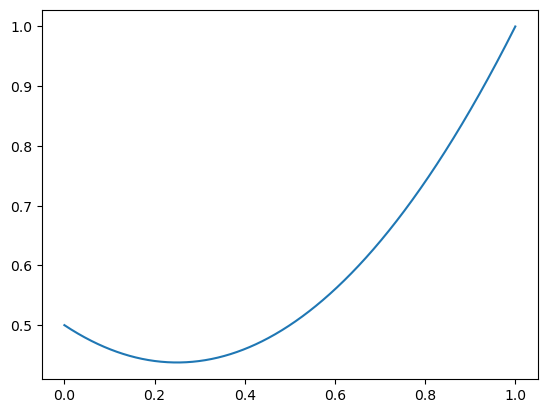

In [19]:
x = np.linspace(0,1,1000)
y = x**2 + 0.5*(1-x)
plt.plot(x,y)
plt.show()

The minimum is at 0.25. But interesting this is not the equilibria! At equilibria we either have all on A (cost=1) or all on B (cost=0.5) or indifferent between either (half on A, half on B, total cost = 0.5). So everyone on B is the pure equilibria, but there is also a mixed one at 0.5 on each.

### 6.4.5: Selfish routing and the price of anarchy

Selfish routing is a model about how selfish agents route through a congested network. We now see these as special types of congestion game. There are a bunch of nodes, some of which are sources and sinks, and costs on each edge depending on the amount of traffic it carries. Finally there is a target amount of traffic that needs to flow from each source to each sink. We can encode this as a nonatomic congestion game by saying each source-sink pair is a type, with an amount needed, the resources are each edge, the actions are all the paths, the congestion contribution is always 1, and the cost is just the edge cost function. 

Because of this we know that selfish routing problems have a pure nash equilibrium and all equilibria have the same social cost. In the example above we saw there were two equilibria with a value of 0.5 each. An interesting question is what the difference is between the minimum social cost (0.25 above) and the equilibria social cost. This is termed the price of anarchy.

**Definition:** The price of anarchy is defined as the ratio between the social cost under the equilibrium policy divided by the social cost under the optimal policy.

For example, in the case above the ratio would be 0.5/0.25 = 2.

We want to know when the price of anarchy is high as we might need to change the network, or invest in reducing costs. 

The price of anarchy can tend to infinity in certain circumstances. Consider the following graph:

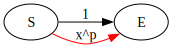

In [31]:
graph1 = Digraph()
graph1.attr(rankdir='LR')
graph1.node('S', 'S')
graph1.node('E', 'E')
graph1.edge('S', 'E', '1', color="black")
graph1.edge('S', 'E', 'x^p', color="red")
display(graph1)

The equilibria is that everyone takes the red route, at a cost of 1. But the best option minimizes $x^{p+1}+(1-x)$, which is at $(p+1)^{-1/p}$. Graph:

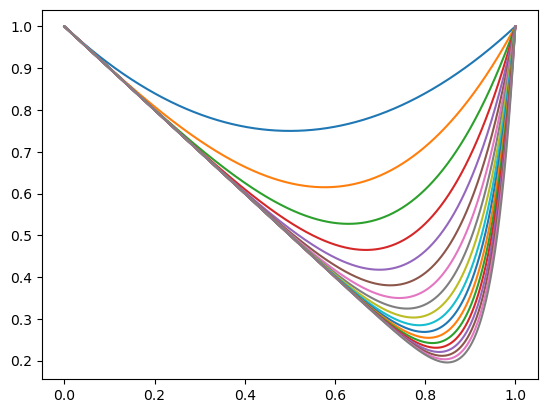

In [38]:
x = np.linspace(0,1,1000)
for p in range(2,20):
    y = x**p + (1-x)
    plt.plot(x,y)
plt.show()

The equilibria remains at a social cost of 1, but the optimal value is dropping with $p$, eventually tending to 0. This means the price of anarchy is likewise tending to infinity.

**Bounding the price of anarchy:**

One interesting result is that we can bound the price of anarchy if we know the costs functions come from some restricted set $C$. In particular, the bound is given by:

$$\sup_{c\in C}\sup_{x,r>0}\frac{r\cdot c(r)}{x\cdot c(x)+(r-x)c(r)}$$

NOTE: $\sup$ is basically just max except $\sup {x : x< 1} $ is 1... Or something like that.

As an example, let's imagine that the cost function is linear. So we can rewrite this using some $w$ (ignoring $b$ for now) as:

$$\sup_{w}\sup_{x,r>0}\frac{r\cdot wr}{x\cdot wx+(r-x)wr}$$

Which can be factorized as:

$$\sup_{w}\sup_{x,r>0}\frac{wr^2}{wx^2+wr^2-wxr}$$

Diving by $w$ we can remove that bit entirely...

$$\sup_{x,r>0}\frac{r^2}{x^2+r^2-xr}$$

Dividing by $\frac{r^2}{r^2}$:

$$\sup_{x,r>0}\frac{1}{\frac{x^2}{r^2}+1-\frac{x}{r}}$$

Maximizing this means minimizing $\frac{x^2}{r^2}-\frac{x}{r}$. Blah blah blah, this ends up being $1/4$. Therefore the final bound is $3/4$!

This is a well-known result.

The concept can also be extended to general nonatomic games.

**Reducing the social cost of selfish routing:**

Consider this graph:

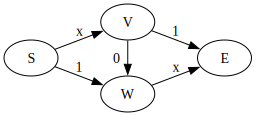

In [44]:
graph1 = Digraph()
graph1.attr(rankdir='LR')
graph1.node('S', 'S')
graph1.node('E', 'E')
graph1.node('W', 'W')
graph1.node('V', 'V')
graph1.edge('S', 'W', '1', color="black")
graph1.edge('S', 'V', 'x', color="black")
graph1.edge('V', 'W', '0', color="black")
graph1.edge('V', 'E', '1', color="black")
graph1.edge('W', 'E', 'x', color="black")
with graph1.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('W')
    same_rank.node('V')
display(graph1)

The best answer is obviously to have half the agents go S-W-E and the other half go S-V-E. However, the equilibrium is everyone going S-V-W-E. Why? Well, it's always better to be on the $x$ road than the 1 road. So the total cost is 2. But the cost of splitting it is $\frac{1}{2}(\frac{1}{2}+1)+\frac{1}{2}(1+\frac{1}{2})=1.5$. Note this gives the worst-case ratio of 4/3.

Interestingly if we just remove the arrow from V to W things improve! Now agents are ambivalent between options, so splitting it 50:50 is an equilibrium.

Unfortunately the problem of determining whether there exists a set of edges whose removal would reduce the social cost is NP-complete. Likewise this makes optimizing this was NP-complete too.

Another alternative is to try to decrease the costs on the edges. There is a theorem that even just turning $c(x)$ into $c(x/2)/2$ can give improvements even greater than changing people's behaviour in the original problem.

There are various bits of literature which also look at other ideas, such as taxes.